Background: Company X had created an app with energy report dashboard, energy breakdown etc for the domestic utility industry. Utility company Y had given it a trial among its customer base for a duration of 9months. The app has 10 screens: Activate, Breakdown, Challenge, Energy_History, Energy_Reports, Feed, Forgot_password, Other, Settings, Trend.

Data: Each month there are different cohort of customer signed up for the app. We have a monthly app usage time by screens for each consumerID. (ie. consumer A accessed and stayed on 'Activation' screen for 3seconds, 'Energy Report' screen for 1minute etc.) There are 5286 uniqe customer ID * 10 columns screen usage time for each month (for 9 months) in the raw data. Albeit the users started using the app at different starting month.

Problem: We would like to find out if we can build a model predicting an user will be active or inactive based on previous month screen usage breakdown.


In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn import tree 



In [5]:
def df_format(df):
    '''
    Formatting the data: 1) set ID as index column, drop blanks, column naming convention
    2) define active usage of the app: if an user accessed any screen more than 3 seconds on given any month (other than 
    Setting, forgetting passwords or activation page)

    '''
    df.rename(columns={ df.columns[0]: "ID" }, inplace=True)
    df.set_index('ID',inplace=True)
    df.columns=df.columns.str.replace(" ","_")
    df[df.select_dtypes(include=['number']).columns] *= (24*60)
    try:
        df['total-pw-setting']=(df['Grand_Total']-df['Forgot_password']-df['Settings']-df['Activate'])
        df['Target']=df['total-pw-setting'].apply(lambda x: 0 if x<3 else 1)
        df.drop(['(blank)','Grand_Total'], axis=1, inplace=True)
    except KeyError:
        return 
    

In [6]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''Make Confusion Matrix Pretty'''
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:

#Extract Data 

May18=pd.read_excel('May18.xlsx')
Jun18=pd.read_excel('Jun18.xlsx')
Jul18=pd.read_excel('Jul18.xlsx')
Aug18=pd.read_excel('Aug18.xlsx')
Sep18=pd.read_excel('Sep18.xlsx')
Oct18=pd.read_excel('Oct18.xlsx')
Nov18=pd.read_excel('Nov18.xlsx')
Dec18=pd.read_excel('Dec18.xlsx')
Jan19=pd.read_excel('Jan19.xlsx')
Feb19=pd.read_excel('Feb19.xlsx')
Mar19=pd.read_excel('Mar19.xlsx')



In [8]:
May18.describe()

,Activate,Breakdown,Challenge,Energy History,Energy Reports,Feed,Forgot password,Other,Settings,Trend,(blank),Grand Total
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.0,491.000000
mean,0.000017,0.000681,0.000178,0.001194,0.000770,0.000444,0.000041,0.000026,0.001120,0.001192,0.0,0.005662
std,0.000091,0.001370,0.000598,0.002506,0.001464,0.000648,0.000174,0.000144,0.001659,0.002730,0.0,0.007423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000069,0.0,0.001122
50%,0.000000,0.000156,0.000000,0.000283,0.000301,0.000254,0.000000,0.000000,0.000217,0.000355,0.0,0.003459
75%,0.000000,0.000702,0.000113,0.001225,0.000906,0.000624,0.000000,0.000000,0.001928,0.001030,0.0,0.007099
max,0.001200,0.011771,0.008384,0.025933,0.016124,0.005866,0.002003,0.001777,0.009308,0.027479,0.0,0.057409


Re-format

In [9]:

df_format(May18)
df_format(Jun18)
df_format(Jul18)
df_format(Aug18)
df_format(Sep18)
df_format(Oct18)
df_format(Nov18)
df_format(Dec18)
df_format(Jan19)
df_format(Feb19)
df_format(Mar19)


In [10]:
May18.describe()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,0.024967,0.981199,0.256289,1.719028,1.108702,0.639526,0.058336,0.036842,1.612881,1.715928,6.457513,0.484725
std,0.131005,1.972921,0.860522,3.609056,2.108185,0.932689,0.250584,0.207869,2.388561,3.930851,9.744339,0.500276
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.004800,0.000000,0.000000,0.000000,0.098917,1.075225,0.000000
50%,0.000000,0.225150,0.000000,0.407750,0.433117,0.365917,0.000000,0.000000,0.312950,0.511433,2.846783,0.000000
75%,0.000000,1.010400,0.163258,1.764617,1.304875,0.897900,0.000000,0.000000,2.776033,1.483225,7.562450,1.000000
max,1.727317,16.950950,12.073300,37.342950,23.217867,8.447083,2.883783,2.559183,13.404100,39.569517,74.173183,1.000000


Merge data: combining app usage time from Month T and target outcome of active/inactive in month T+1.

In [11]:
df_target_Jun18=pd.merge(May18.iloc[:,0:11],Jun18.Target,left_index=True, right_index=True, how="left")
df_target_Jul18=pd.merge(Jun18.iloc[:,0:11],Jul18.Target,left_index=True, right_index=True, how="left")
df_target_Aug18=pd.merge(Jul18.iloc[:,0:11],Aug18.Target,left_index=True, right_index=True, how="left")
df_target_Sep18=pd.merge(Aug18.iloc[:,0:11],Sep18.Target,left_index=True, right_index=True, how="left")
df_target_Oct18=pd.merge(Sep18.iloc[:,0:11],Oct18.Target,left_index=True, right_index=True, how="left")
df_target_Nov18=pd.merge(Oct18.iloc[:,0:11],Nov18.Target,left_index=True, right_index=True, how="left")
df_target_Dec18=pd.merge(Nov18.iloc[:,0:11],Dec18.Target,left_index=True, right_index=True, how="left")
df_target_Jan19=pd.merge(Dec18.iloc[:,0:11],Jan19.Target,left_index=True, right_index=True, how="left")
df_target_Feb19=pd.merge(Jan19.iloc[:,0:11],Feb19.Target,left_index=True, right_index=True, how="left")
df_target_Mar19=pd.merge(Feb19.iloc[:,0:11],Mar19.Target,left_index=True, right_index=True, how="left")

df_comb=pd.DataFrame()
df_comb=pd.concat([df_target_Jun18,
                   df_target_Jul18,
                   df_target_Aug18,
                   df_target_Sep18,
                   df_target_Jun18,
                   df_target_Jul18,
                   df_target_Aug18,
                   df_target_Sep18,
                   df_target_Oct18,
                   df_target_Nov18,
                   df_target_Dec18,
                   df_target_Jan19,
                   df_target_Feb19,
                   df_target_Mar19
                  ], sort=False)
df_comb.Target.fillna(0, inplace=True)
df_comb.describe()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target,Right_Now,Grand_Total
count,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,982.000000,21864.000000,2216.000000,18666.000000
mean,0.001121,1.200974,0.229744,1.794978,1.178358,1.025101,0.002620,0.141309,1.341226,1.905681,6.457513,0.268798,0.000060,9.602953
std,0.028214,27.065985,4.588918,39.875377,27.764501,27.622096,0.054412,0.691615,19.561587,41.936254,9.739372,0.443345,0.002012,201.905110
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.001450,0.000000,0.000000,0.000000,0.000000,1.071254,0.000000,0.000000,0.918212
50%,0.000000,0.144933,0.000000,0.163792,0.142800,0.360567,0.000000,0.000000,0.068542,0.192958,2.846783,0.000000,0.000000,3.445733
75%,0.000000,0.949567,0.000000,1.185604,0.961742,0.914146,0.000000,0.000000,1.361312,1.095975,7.577050,1.000000,0.000000,8.192583
max,1.727317,2933.794167,530.075400,4256.898483,3047.709000,2832.671050,2.883783,18.245583,2485.562317,4608.315900,74.173183,1.000000,0.067000,20713.271900


In [12]:
df_comb.head()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target,Right_Now,Grand_Total
ID,,,,,,,,,,,,,,
ABDHFCJIDCF,0.0,0.000000,0.000000,0.000000,0.000000,0.770250,0.0000,0.691683,10.692783,0.857233,2.319167,1.0,NaN,NaN
ABDHGHGIDGD,0.0,2.173883,0.000000,0.185200,2.342733,1.650767,0.0000,0.000000,0.000000,1.576650,7.929233,1.0,NaN,NaN
ABEGFGFCCAI,0.0,5.532900,1.020917,16.544500,4.483817,4.754350,0.7303,0.000000,4.336717,1.968683,34.305167,0.0,NaN,NaN
ABEMGELDDIC,0.0,3.401117,0.303483,0.866283,2.902100,2.243750,0.0000,0.000000,12.313850,8.189450,17.906183,1.0,NaN,NaN
ABFHFIJJEGC,0.0,3.716900,1.021683,2.196500,7.875067,3.144817,0.0000,0.000000,6.252467,2.053500,20.008467,1.0,NaN,NaN


In [13]:
df_comb.drop(['Right_Now','Grand_Total'],axis=1,inplace=True)
df_comb.head()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target
ID,,,,,,,,,,,,
ABDHFCJIDCF,0.0,0.000000,0.000000,0.000000,0.000000,0.770250,0.0000,0.691683,10.692783,0.857233,2.319167,1.0
ABDHGHGIDGD,0.0,2.173883,0.000000,0.185200,2.342733,1.650767,0.0000,0.000000,0.000000,1.576650,7.929233,1.0
ABEGFGFCCAI,0.0,5.532900,1.020917,16.544500,4.483817,4.754350,0.7303,0.000000,4.336717,1.968683,34.305167,0.0
ABEMGELDDIC,0.0,3.401117,0.303483,0.866283,2.902100,2.243750,0.0000,0.000000,12.313850,8.189450,17.906183,1.0
ABFHFIJJEGC,0.0,3.716900,1.021683,2.196500,7.875067,3.144817,0.0000,0.000000,6.252467,2.053500,20.008467,1.0


Start to understand the Data & filtering

In [14]:
df_comb.describe()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target
count,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,21864.000000,982.000000,21864.000000
mean,0.001121,1.200974,0.229744,1.794978,1.178358,1.025101,0.002620,0.141309,1.341226,1.905681,6.457513,0.268798
std,0.028214,27.065985,4.588918,39.875377,27.764501,27.622096,0.054412,0.691615,19.561587,41.936254,9.739372,0.443345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.001450,0.000000,0.000000,0.000000,0.000000,1.071254,0.000000
50%,0.000000,0.144933,0.000000,0.163792,0.142800,0.360567,0.000000,0.000000,0.068542,0.192958,2.846783,0.000000
75%,0.000000,0.949567,0.000000,1.185604,0.961742,0.914146,0.000000,0.000000,1.361312,1.095975,7.577050,1.000000
max,1.727317,2933.794167,530.075400,4256.898483,3047.709000,2832.671050,2.883783,18.245583,2485.562317,4608.315900,74.173183,1.000000


There are clearly outliers in the dataset by looking at Max vs 50% and mean. Let's get rid off all data that's greater than 500.

In [15]:
#the box chart suggests that there are outliars need to be treated. set filter to less than 500s per screen.
df_comb=df_comb[df_comb['Energy_History']<500]
df_comb.describe()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target
count,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,21860.000000,982.000000,21860.000000
mean,0.001122,0.861229,0.174169,1.286183,0.831151,0.683270,0.002621,0.139522,1.132500,1.395157,6.457513,0.268664
std,0.028217,1.884131,0.728474,3.374971,1.735021,1.028121,0.054417,0.670999,3.980058,7.163078,9.739372,0.443275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.001446,0.000000,0.000000,0.000000,0.000000,1.071254,0.000000
50%,0.000000,0.144817,0.000000,0.163475,0.142642,0.360450,0.000000,0.000000,0.068517,0.192783,2.846783,0.000000
75%,0.000000,0.948925,0.000000,1.184925,0.961092,0.913750,0.000000,0.000000,1.360208,1.095042,7.577050,1.000000
max,1.727317,54.176550,20.007183,105.785017,35.571283,15.695217,2.883783,17.824600,336.753183,524.651983,74.173183,1.000000


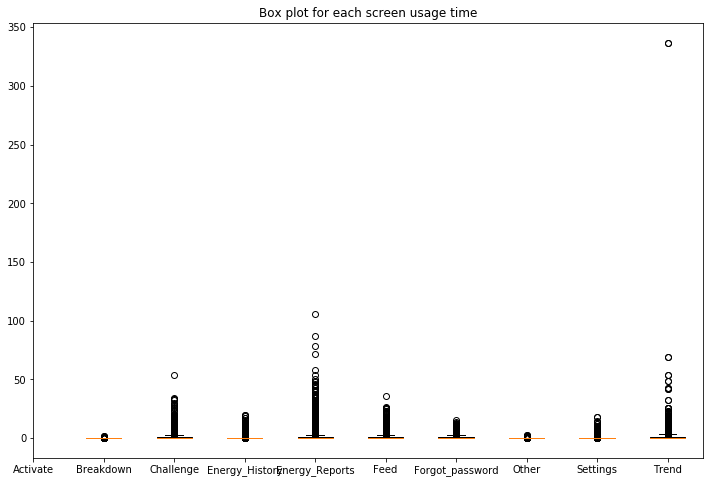

In [16]:


plt.figure(figsize=(12, 8))
plt.boxplot([df_comb[col] for col in df_comb.columns[:-3]])
plt.title("Box plot for each screen usage time")
plt.xticks(range(len(df_comb.columns[:-2].values)), df_comb.columns[:-2].values)
plt.show()

The most valuablable screen for this app is Energy Reports and Trend. The company should not be spending time on refining breakdown page.

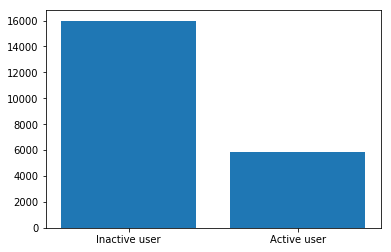

Zeros/Inactive:  0.7313357731015554
Ones/Active:  0.26866422689844466


In [17]:
import numpy as np
ones=df_comb.Target.sum()
zeros=len(df_comb.Target)-ones
height=[zeros,ones]
bars=("Inactive user", "Active user")
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos,bars)
plt.show()

print('Zeros/Inactive: ', zeros/(zeros+ones))
print('Ones/Active: ', ones/(zeros+ones))


Baseline data is skewed to Inactive/zeros. Need to resample and use balanced dataset.

Start splitting training and testing dataset.

In [18]:
X = df_comb[df_comb.columns]
y = df_comb.Target
x_train, X_test, y_train, y_test=train_test_split(X,y,random_state=1)
x_train.head()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend,total-pw-setting,Target
ID,,,,,,,,,,,,
BILDLCEJEHC,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,NaN,0.0
ABEELDFGCHJ,0.0,0.750317,6.973733,14.084967,4.648450,0.848567,0.0,0.0,2.445450,5.261817,NaN,1.0
AJIDEFIHECC,0.0,0.211833,0.000000,0.540333,0.063967,1.599267,0.0,0.0,0.246967,0.796017,NaN,0.0
ADKFFJIIFAG,0.0,0.202333,0.000000,0.015400,0.888567,0.046517,0.0,0.0,3.343967,0.177867,NaN,0.0
ABGLELFIEHJ,0.0,0.000000,0.000000,0.347550,1.374433,0.000000,0.0,0.0,0.000000,2.021400,3.743383,0.0


Create a balanced dataset for training.

In [19]:
X_balance = pd.concat([x_train[x_train.Target==0].sample(len(x_train[x_train['Target'] == 1])), 
                 x_train[x_train['Target'] == 1]])
y_train=X_balance.Target
X_train=X_balance[X_balance.columns[:-2]]
X_test=X_test[X_test.columns[:-2]]
X_train.head()

,Activate,Breakdown,Challenge,Energy_History,Energy_Reports,Feed,Forgot_password,Other,Settings,Trend
ID,,,,,,,,,,
AKKDLCHJFBE,0.0000,1.870767,0.00000,2.197800,0.128800,0.382400,0.000000,0.0,0.507100,0.229567
AGDJEHMIFBD,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
BGDDFIMEDJH,0.1814,0.000000,0.12695,0.718917,0.875467,0.000000,0.702117,0.0,2.518233,0.778217
BJDJFJHHEJH,0.0000,1.703450,0.00000,0.042833,2.542017,1.548267,0.000000,0.0,7.289333,1.996250
BELMHLEGFID,0.0000,2.652767,0.00000,2.118133,1.344900,0.981300,0.000000,0.0,0.247050,0.000000


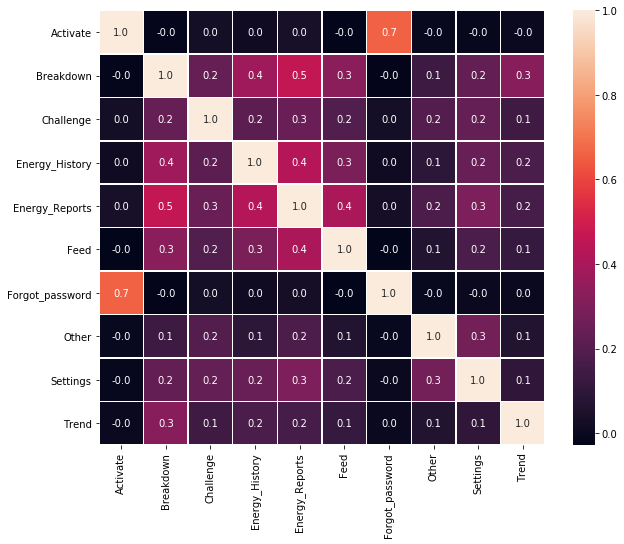

In [20]:
#correlation map
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(X_test.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Variables are well de-correlated, apart from 'Forget Password' and 'activation', which is expected.

In [21]:
#Fit a Logistic Regression Model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, random_state=1) #Starter code
model_log=logreg.fit(X_train, y_train)
model_log

/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#Predict
y_pred=logreg.predict(X_test)
y_hat_train=logreg.predict(X_train)

In [23]:
#Evaluation
res=y_train-y_hat_train
print(pd.Series(res).value_counts())
print(pd.Series(res).value_counts(normalize=True))

 0.0    5442
-1.0    2914
 1.0     498
Name: Target, dtype: int64
 0.0    0.614637
-1.0    0.329117
 1.0    0.056246
Name: Target, dtype: float64


62% time that we are correct in predicting a balanced training set. this is 12% than baseline training set of 50%

The model seems better at predicting True Negative case, ie predicting that a user will be inactive next month based on previous month usage. However, it is bad (less than random chance of 50%) at predicting a usere becomes active despite inactivity over the last month. Overall accuracy is (0.76+0.48)/2=62%.

ROC is: 0.7395320016918255
f1: 0.490525509697403
Accuracy is:  0.48508691674290944
Normalized confusion matrix
[[0.34585718 0.65414282]
 [0.12793914 0.87206086]]


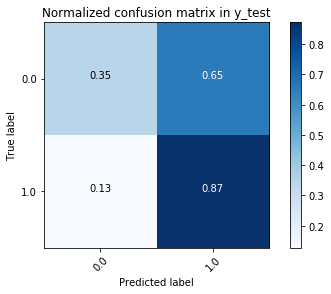

In [26]:
#Evaluating result for logistic Regression

#ROC curve

from sklearn.metrics import roc_curve, auc,f1_score

#First calculate the probability scores of each of the datapoints:
y_score = model_log.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

y_train_score = model_log.decision_function(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
print('ROC is: {}'.format(auc(fpr, tpr)))

print('f1: {}'.format(f1_score(y_test, y_pred,average='weighted')))

ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,y_pred)
class_names=set(y)
plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Normalized confusion matrix in y_test')



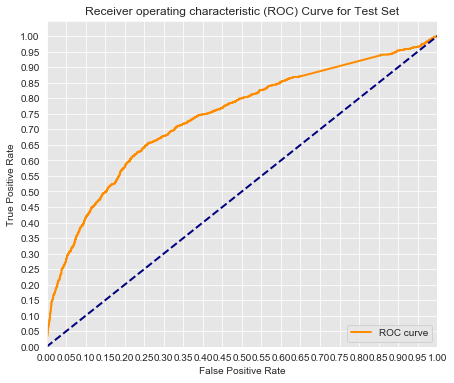

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(7,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")


In [28]:
#Try Decision Tree Model


In [29]:
#Default parameters
clf= DecisionTreeClassifier(random_state=1)
clf.fit(X_train,y_train) 
y_pred = clf.predict(X_test)

ROC is:  0.6891706819990935
f1: 0.7146972851748866
Accuracy is:  0.7000914913083257
Normalized confusion matrix
[[0.71236626 0.28763374]
 [0.3340249  0.6659751 ]]


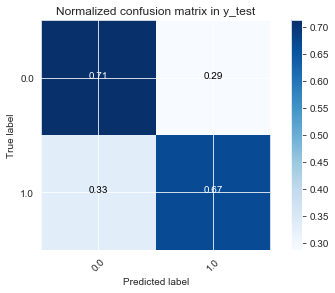

In [30]:
#Evaluating the Decision Tree Model
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


print('ROC is: ', roc_auc)

print('f1: {}'.format(f1_score(y_test, y_pred,average='weighted')))

ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,y_pred)

plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Normalized confusion matrix in y_test')

AUC: 0.6891706819990935


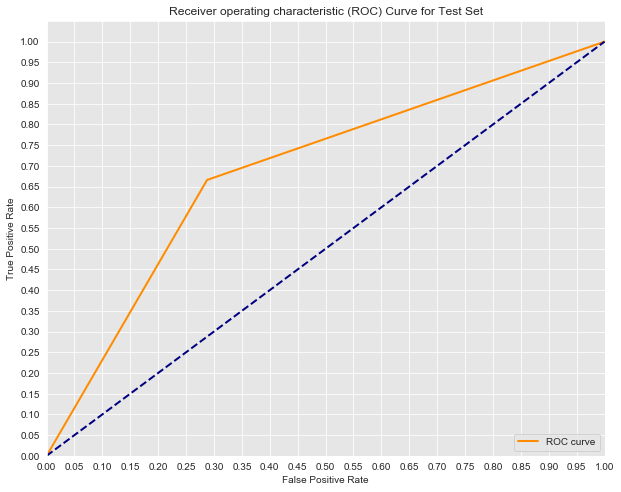

In [31]:
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

The AUC of 69% is similar to Logistic Regression Result.

In [48]:
#Fine Tuning parameters:

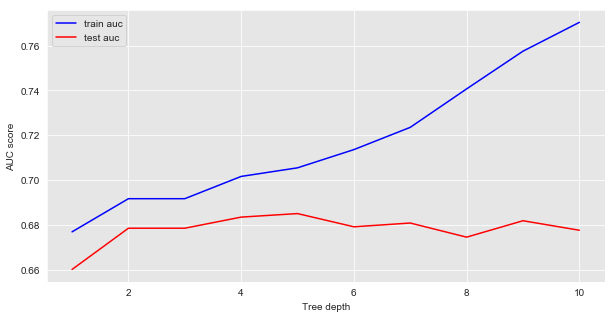

In [47]:
# 1. Identify the optimal tree depth for given data
max_depths=np.linspace(1,10,10, endpoint=True)
train_results=[]
test_results=[]
for max_depth in max_depths:
    dt=DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred=dt.predict(X_train)
    fpr,tpr,thresholds=roc_curve(y_train, train_pred)
    roc_auc=auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred=dt.predict(X_test)
    fpr, tpr, thresholds=roc_curve(y_test, y_pred)
    roc_auc=auc(fpr, tpr)
    test_results.append(roc_auc)
plt.figure(figsize=(10,5))
plt.plot(max_depths, train_results, 'b', label='train auc')
plt.plot(max_depths, test_results, 'r', label='test auc')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

Training error decreases with increasing tree depth - sign of over fitting.
Test error is static after depth=3 - marginal improvement of less than 2% to learn from deeper trees.
Optimal value seen here is between 5 to 6.

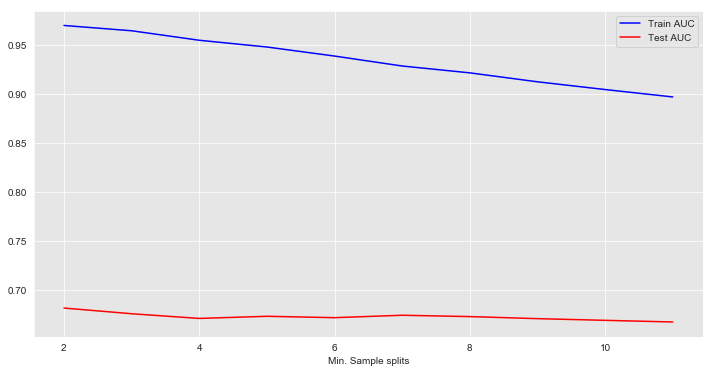

In [33]:
# Identify the optimal min-samples-split for given data

min_sample_splits=np.linspace(2, 11, 10, endpoint=True)
train_results=[]
test_results=[]
for mss in min_sample_splits:
    dt=DecisionTreeClassifier(criterion='entropy', min_samples_split=int(mss))
    dt.fit(X_train, y_train)
    train_pred=dt.predict(X_train)
    fpr, tpr, thresholds=roc_curve(y_train, train_pred)
    roc_auc=auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred=dt.predict(X_test)
    fpr, tpr, thresholds=roc_curve(y_test, y_pred)
    roc_auc=auc(fpr, tpr)
    test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(min_sample_splits, train_results, 'b', label='Train AUC')
plt.plot(min_sample_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

Best Test AUC occurs at around 2, 3 for both curves.

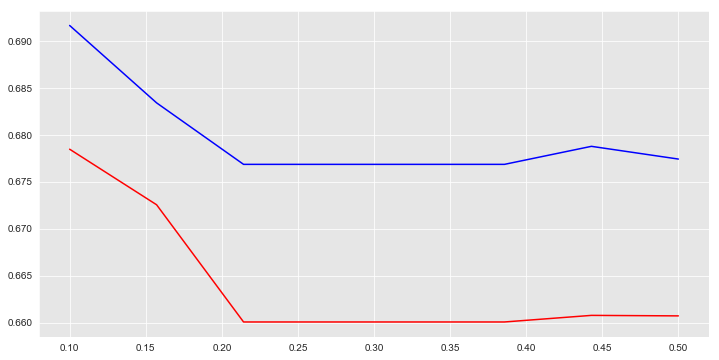

In [34]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs=np.linspace(0.1,0.5, 8, endpoint=True)
train_results=[]
test_results=[]
for msl in min_samples_leafs:
    dt=DecisionTreeClassifier(criterion='entropy', min_samples_leaf=msl)
    dt.fit(X_train, y_train)
    train_pred=dt.predict(X_train)
    fpr, tpr, thesholds=roc_curve(y_train, train_pred)
    roc_auc=auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred=dt.predict(X_test)
    fpr, tpr, thresholds=roc_curve(y_test, y_pred)
    roc_auc=auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, train_results, 'b', label='train auc')
plt.plot(min_samples_leafs, test_results, 'r', label='test auc')
plt.show()

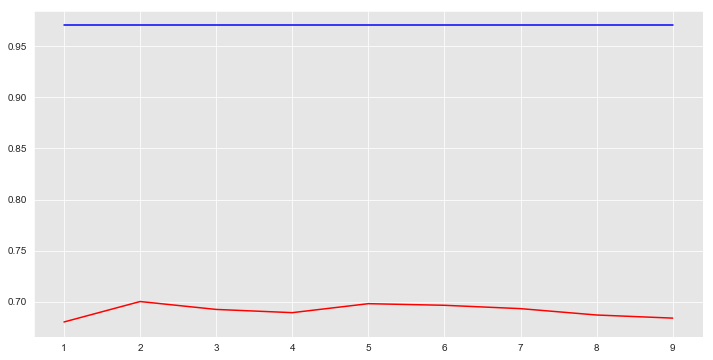

In [35]:
# Find the best value for optimal maximum feature size

max_features=list(range(1, X_train.shape[1]))
train_results=[]
test_results=[]
for max_feature in max_features:
    dt=DecisionTreeClassifier(criterion='entropy', max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred=dt.predict(X_train)
    fpr, tpr, t=roc_curve(y_train, train_pred)
    roc_auc=auc(fpr, tpr)
    train_results.append(roc_auc)
    
    y_pred=dt.predict(X_test)
    fpr, tpr, t=roc_curve(y_test, y_pred)
    roc_auc=auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b',label='train auc')
plt.plot(max_features, test_results, 'r', label='test auc')
plt.show() 

no clear number, fluctuating, it seems 2 and 3 are the highest point for the test AUC. 

In [40]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,5,6],
    'min_samples_split': [ 2,3],
    'max_features': [ 2, 3,4]
}

In [41]:
dt_grid_search = GridSearchCV(clf, dt_param_grid, cv=3, return_train_score=True, scoring="f1")
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6], 'max_features': [2, 3, 4],
    

In [42]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X_train, y_train)


print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 68.63%
Mean Testing Score: 67.69%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 4,
 'min_samples_split': 2}

With the optimal parameters, we were able to improve the accuracy by 10% from 80% to 91%.

ROC is:  0.6840025439329162
f1: 0.7402959786094714
Accuracy is:  0.7344922232387923
Normalized confusion matrix
[[0.7912416  0.2087584 ]
 [0.42323651 0.57676349]]


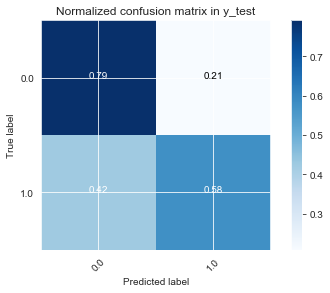

In [43]:

# train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=4,
                           max_depth=5,
                           min_samples_split=2, random_state=1
                        
                           )
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
fpr, tpr, t=roc_curve(y_test, y_pred)
roc_auc=auc(fpr, tpr)
print('ROC is: ', roc_auc)

print('f1: {}'.format(f1_score(y_test, y_pred,average='weighted')))

ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,y_pred)
class_names=set(y)
plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Normalized confusion matrix in y_test')

Decision Tree significantly improved F1 score.
Especially in predicting True Negative.
Between Default Model and Optimized model, Optimized model does a better job in predicting accuracy and f1. 
However, it is worth noting that Optimized model did worse in predicting True Positive vs Default Model.


In [45]:
#Try Random Forest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rf_clf = RandomForestClassifier(random_state=1)


In [46]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,5,6],
    'min_samples_split': [ 2,3],
    'max_features': [ 3,4, 5]

}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)


print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 100}


ROC is:  0.702822812250386
f1: 0.739099755914684
Accuracy is:  0.728636779505947
Normalized confusion matrix
[[0.75765116 0.24234884]
 [0.35200553 0.64799447]]


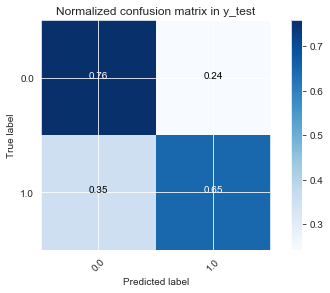

In [49]:
y_pred=rf_grid_search.predict(X_test)
fpr, tpr, t=roc_curve(y_test, y_pred)
roc_auc=auc(fpr, tpr)
print('ROC is: ', roc_auc)

print('f1: {}'.format(f1_score(y_test, rf_grid_search.predict(X_test),average='weighted')))

ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,y_pred)
class_names=set(y)
plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Normalized confusion matrix in y_test')

Random Forest with grid search has the same f1 score as optimized Decision Tree, but better at predicting True Positive.


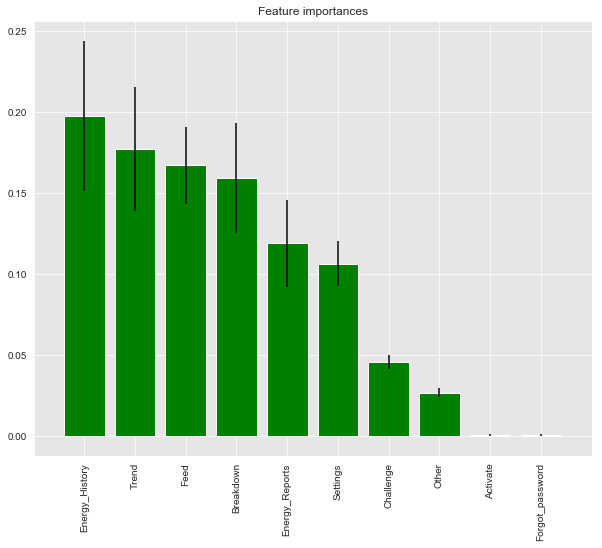

In [52]:
rf_clf.fit(X_train,y_train)
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(1, figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Looking at the feature importance on Random Forest Model, we can see that the top 3 feature screens of the app explains more than 50% of the outcome. Ie. If an user access the app in the trend, Energy History, and feed pages in the previous month, it is very likely that the user will stay active in the current month.


ROC is:  0.6884207861895278
f1: 0.739099755914684
Accuracy is:  0.7269899359560842
Normalized confusion matrix
[[0.77034088 0.22965912]
 [0.39349931 0.60650069]]


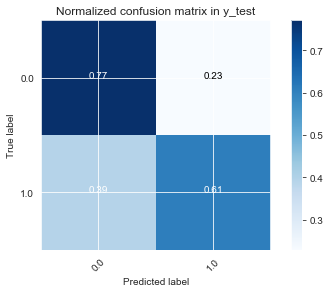

In [51]:
adaboost_clf = AdaBoostClassifier(random_state=1)
adaboost_clf.fit(X_train,y_train)

y_pred=adaboost_clf.predict(X_test)
fpr, tpr, t=roc_curve(y_test, y_pred)
roc_auc=auc(fpr, tpr)
print('ROC is: ', roc_auc)

print('f1: {}'.format(f1_score(y_test, rf_grid_search.predict(X_test),average='weighted')))

ac = accuracy_score(y_test,y_pred)
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,y_pred)
class_names=set(y)
plot_confusion_matrix(cm, classes=class_names,normalize=True,
                      title='Normalized confusion matrix in y_test')

Adaboost is similar to Random Forest, marginal worse on AUC.

In [69]:
df_names=[May18, Jun18,Jul18,Aug18,Sep18,Oct18,Nov18, Dec18, Jan19, Feb19, Mar19]

user=[]
user_list_may=[]
user_list_may.append(len(May18))
for idx, name in enumerate(df_names):
    
    try:
        y=pd.concat([May18,df_names[idx+1]], axis=1, join="inner")
        user_list_may.append(y.shape[0])
    except IndexError:
        continue

user_list_jun=[]
user_list_jun.append(len(Jun18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Jun18,df_names[idx+2]], axis=1, join="inner")
        user_list_jun.append(y.shape[0])
    except IndexError:
        continue
        
user_list_jul=[]
user_list_jul.append(len(Jul18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Jul18,df_names[idx+3]], axis=1, join="inner")
        user_list_jul.append(y.shape[0])
    except IndexError:
        continue
        
user_list_aug=[]
user_list_aug.append(len(Aug18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Aug18,df_names[idx+4]], axis=1, join="inner")
        user_list_aug.append(y.shape[0])
    except IndexError:
        continue

user_list_sep=[]
user_list_sep.append(len(Sep18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Sep18,df_names[idx+5]], axis=1, join="inner")
        user_list_sep.append(y.shape[0])
    except IndexError:
        continue
        
user_list_oct=[]
user_list_oct.append(len(Oct18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Oct18,df_names[idx+6]], axis=1, join="inner")
        user_list_oct.append(y.shape[0])
    except IndexError:
        continue
        
user_list_nov=[]
user_list_nov.append(len(Nov18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Nov18,df_names[idx+7]], axis=1, join="inner")
        user_list_nov.append(y.shape[0])
    except IndexError:
        continue
        
user_list_dec=[]
user_list_dec.append(len(Dec18))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Dec18,df_names[idx+8]], axis=1, join="inner")
        user_list_dec.append(y.shape[0])
    except IndexError:
        continue
        
user_list_jan=[]
user_list_jan.append(len(Jan19))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Jan19,df_names[idx+9]], axis=1, join="inner")
        user_list_jan.append(y.shape[0])
    except IndexError:
        continue
        
user_list_feb=[]
user_list_feb.append(len(Feb19))
for idx, name in enumerate(df_names):
    try:
        y=pd.concat([Feb19,df_names[idx+10]], axis=1, join="inner")
        user_list_feb.append(y.shape[0])
    except IndexError:
        continue

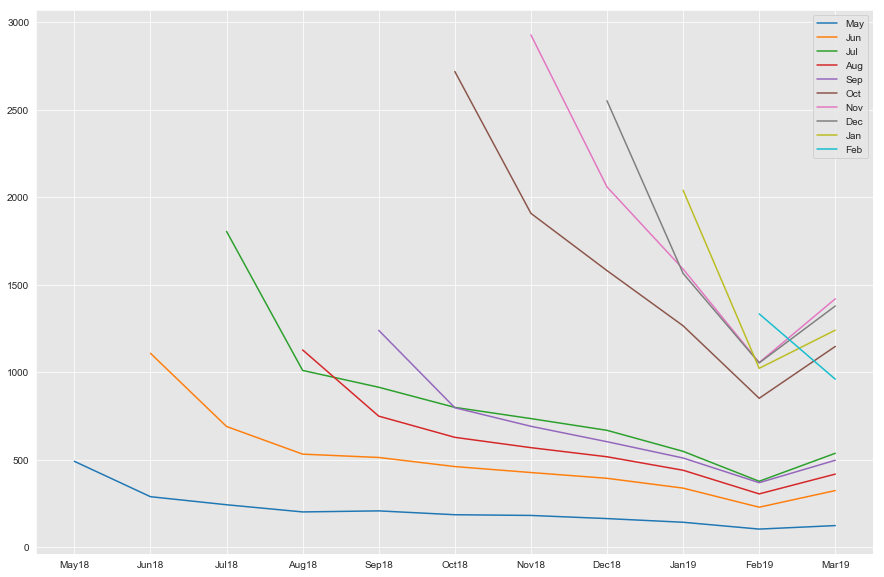

In [71]:
timeline=['May18', 'Jun18', 'Jul18', 'Aug18', 'Sep18', 'Oct18', 'Nov18', 'Dec18', 'Jan19','Feb19', 'Mar19']
plt.figure(figsize=(15, 10))
plt.plot(timeline, user_list_may, label='May')
plt.plot(timeline[1:], user_list_jun, label='Jun')
plt.plot(timeline[2:], user_list_jul, label='Jul')
plt.plot(timeline[3:], user_list_aug, label='Aug')
plt.plot(timeline[4:], user_list_sep, label='Sep')
plt.plot(timeline[5:], user_list_oct, label='Oct')
plt.plot(timeline[6:], user_list_nov, label='Nov')
plt.plot(timeline[7:], user_list_dec, label='Dec')
plt.plot(timeline[8:], user_list_jan, label='Jan')
plt.plot(timeline[9:], user_list_feb, label='Feb')
plt.legend()